# Probing GCN MDD

Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset_MDD
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? False


In [2]:
dataset = read_dataset_MDD()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has MDD
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
print('Number of samples:', len(dataset))


Data(x=[116, 116], edge_index=[2, 1294], edge_attr=[1294, 1], y=[1])
['edge_attr', 'y', 'edge_index', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.2857,  0.0804,  ...,  0.2032,  0.1674,  0.0906],
        [ 0.2857,  0.0000, -0.3860,  ...,  0.1637, -0.0359,  0.1674],
        [ 0.0804, -0.3860,  0.0000,  ..., -0.0175, -0.0309,  0.0296],
        ...,
        [ 0.2032,  0.1637, -0.0175,  ...,  0.0000,  0.2329, -0.1452],
        [ 0.1674, -0.0359, -0.0309,  ...,  0.2329,  0.0000,  0.0183],
        [ 0.0906,  0.1674,  0.0296,  ..., -0.1452,  0.0183,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 113, 113, 114],
        [ 10,  12,  14,  ..., 111, 112, 108]]), 'edge_attr': tensor([[0.7785],
        [0.6966],
        [0.5463],
        ...,
        [0.6415],
        [0.4745],
        [0.5401]]), 'y': tensor([0])})
Number of samples: 1604


In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC_MDD"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([1365,  984, 1017,  ...,  260,  678,   83])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#load the model
# gnn.load_model(path="models/"+DATASET+"_"+MODEL+"_computer.pt")

In [9]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [10]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server_gpu.pt")

In [11]:
gnn.evaluate()

Test Loss: 0.649, Train Acc: 1.000 Test Acc: 0.605


### Properties

In [ ]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [ ]:
print(len(train_properties))
train_properties[0:5]



In [12]:
import pickle as pkl
# save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

### Features

In [13]:
train_features, test_features = gnn.evaluate_with_features2()

In [14]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1523, 81)

In [14]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

### Diagnostic classifier

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score


#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

torch.Size([1523, 14848])
torch.Size([81, 14848])
Epoch [1000/2000000], Property: num_nodes, Loss: 2.9572
Epoch [2000/2000000], Property: num_nodes, Loss: 0.3504
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0453
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0162
Epoch [5000/2000000], Property: num_nodes, Loss: 0.0081
Epoch [6000/2000000], Property: num_nodes, Loss: 0.0031
Epoch [7000/2000000], Property: num_nodes, Loss: 0.0009
Epoch [8000/2000000], Property: num_nodes, Loss: 0.0002
Epoch [9000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [10000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [11000/2000000], Property: num_nodes, Loss: 0.0016
Epoch [12000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [13000/2000000], Property: num_nodes, Loss: 0.0073
Early stopping at epoch 13794
Embedding: torch.Size([1523, 116, 128])
Property: num_nodes
  Train MSE: 0.5660, Test MSE: 28.4478
  Train R²: 0.9003, Test R²: -3.5103
Epoch [1000/2000000], Property: num_edges, Loss: 129

Epoch [10000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0001
Epoch [11000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [12000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [13000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0003
Epoch [14000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [15000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Early stopping at epoch 15528
Embedding: torch.Size([1523, 116, 128])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 0.0000, Test MSE: 28.4686
  Train R²: 1.0000, Test R²: -0.3972
Epoch [1000/2000000], Property: assortativity, Loss: 0.0000
Epoch [2000/2000000], Property: assortativity, Loss: 0.0000
Epoch [3000/2000000], Property: assortativi

Epoch [1000/2000000], Property: num_squares, Loss: 0.0001
Epoch [2000/2000000], Property: num_squares, Loss: 0.0000
Epoch [3000/2000000], Property: num_squares, Loss: 0.0021
Epoch [4000/2000000], Property: num_squares, Loss: 0.0000
Epoch [5000/2000000], Property: num_squares, Loss: 0.0000
Epoch [6000/2000000], Property: num_squares, Loss: 0.0000
Early stopping at epoch 6072
Embedding: torch.Size([1523, 116, 128])
Property: num_squares
  Train MSE: 0.0000, Test MSE: 0.4563
  Train R²: 1.0000, Test R²: 0.6732
Epoch [1000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.1828
Epoch [2000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.4857
Epoch [3000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0813
Epoch [4000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0343
Epoch [5000/2000000], Property: number_of_nodes_in_the_largest_fully_connec

Epoch [16000/2000000], Property: num_triangles, Loss: 0.2003
Epoch [17000/2000000], Property: num_triangles, Loss: 0.0533
Epoch [18000/2000000], Property: num_triangles, Loss: 0.0142
Epoch [19000/2000000], Property: num_triangles, Loss: 0.0033
Epoch [20000/2000000], Property: num_triangles, Loss: 0.0007
Epoch [21000/2000000], Property: num_triangles, Loss: 0.0001
Epoch [22000/2000000], Property: num_triangles, Loss: 0.0354
Epoch [23000/2000000], Property: num_triangles, Loss: 0.0002
Epoch [24000/2000000], Property: num_triangles, Loss: 0.0001
Epoch [25000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [26000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [27000/2000000], Property: num_triangles, Loss: 0.0000
Early stopping at epoch 27174
Embedding: torch.Size([1523, 116, 128])
Property: num_triangles
  Train MSE: 0.0000, Test MSE: 98588.8359
  Train R²: 1.0000, Test R²: 0.8007
Epoch [1000/2000000], Property: num_squares, Loss: 0.0001
Epoch [2000/2000000], Property: num_sq

Epoch [8000/2000000], Property: num_triangles, Loss: 1362.2419
Epoch [9000/2000000], Property: num_triangles, Loss: 377.8633
Epoch [10000/2000000], Property: num_triangles, Loss: 86.8053
Epoch [11000/2000000], Property: num_triangles, Loss: 26.8273
Epoch [12000/2000000], Property: num_triangles, Loss: 10.0476
Epoch [13000/2000000], Property: num_triangles, Loss: 3.5546
Epoch [14000/2000000], Property: num_triangles, Loss: 1.3338
Epoch [15000/2000000], Property: num_triangles, Loss: 0.4875
Epoch [16000/2000000], Property: num_triangles, Loss: 0.1457
Epoch [17000/2000000], Property: num_triangles, Loss: 0.0280
Epoch [18000/2000000], Property: num_triangles, Loss: 0.0767
Epoch [19000/2000000], Property: num_triangles, Loss: 0.0691
Epoch [20000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [21000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [22000/2000000], Property: num_triangles, Loss: 0.0329
Epoch [23000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [24000/20000

Epoch [3000/2000000], Property: num_triangles, Loss: 53069.7891
Epoch [4000/2000000], Property: num_triangles, Loss: 33870.5312
Epoch [5000/2000000], Property: num_triangles, Loss: 20458.2578
Epoch [6000/2000000], Property: num_triangles, Loss: 11180.3896
Epoch [7000/2000000], Property: num_triangles, Loss: 5261.1094
Epoch [8000/2000000], Property: num_triangles, Loss: 1989.2386
Epoch [9000/2000000], Property: num_triangles, Loss: 551.0410
Epoch [10000/2000000], Property: num_triangles, Loss: 108.1866
Epoch [11000/2000000], Property: num_triangles, Loss: 21.7512
Epoch [12000/2000000], Property: num_triangles, Loss: 6.1802
Epoch [13000/2000000], Property: num_triangles, Loss: 1.8709
Epoch [14000/2000000], Property: num_triangles, Loss: 0.5801
Epoch [15000/2000000], Property: num_triangles, Loss: 0.1653
Epoch [16000/2000000], Property: num_triangles, Loss: 0.0397
Epoch [17000/2000000], Property: num_triangles, Loss: 0.0062
Epoch [18000/2000000], Property: num_triangles, Loss: 0.0005
Epoc

Epoch [67000/2000000], Property: num_nodes, Loss: 64.3212
Epoch [68000/2000000], Property: num_nodes, Loss: 62.3765
Epoch [69000/2000000], Property: num_nodes, Loss: 60.4637
Epoch [70000/2000000], Property: num_nodes, Loss: 58.5800
Epoch [71000/2000000], Property: num_nodes, Loss: 56.7279
Epoch [72000/2000000], Property: num_nodes, Loss: 54.9067
Epoch [73000/2000000], Property: num_nodes, Loss: 53.1164
Epoch [74000/2000000], Property: num_nodes, Loss: 51.3569
Epoch [75000/2000000], Property: num_nodes, Loss: 49.6283
Epoch [76000/2000000], Property: num_nodes, Loss: 47.9307
Epoch [77000/2000000], Property: num_nodes, Loss: 46.2639
Epoch [78000/2000000], Property: num_nodes, Loss: 44.6281
Epoch [79000/2000000], Property: num_nodes, Loss: 43.0234
Epoch [80000/2000000], Property: num_nodes, Loss: 41.4498
Epoch [81000/2000000], Property: num_nodes, Loss: 39.9122
Epoch [82000/2000000], Property: num_nodes, Loss: 38.4101
Epoch [83000/2000000], Property: num_nodes, Loss: 36.9386
Epoch [84000/2

Epoch [64000/2000000], Property: num_edges, Loss: 14168.9600
Epoch [65000/2000000], Property: num_edges, Loss: 14144.5244
Epoch [66000/2000000], Property: num_edges, Loss: 14120.1230
Epoch [67000/2000000], Property: num_edges, Loss: 14095.7529
Epoch [68000/2000000], Property: num_edges, Loss: 14071.4141
Epoch [69000/2000000], Property: num_edges, Loss: 14047.1074
Epoch [70000/2000000], Property: num_edges, Loss: 14022.8311
Epoch [71000/2000000], Property: num_edges, Loss: 13998.5898
Epoch [72000/2000000], Property: num_edges, Loss: 13974.3799
Epoch [73000/2000000], Property: num_edges, Loss: 13950.1992
Epoch [74000/2000000], Property: num_edges, Loss: 13926.0527
Epoch [75000/2000000], Property: num_edges, Loss: 13901.9355
Epoch [76000/2000000], Property: num_edges, Loss: 13877.8525
Epoch [77000/2000000], Property: num_edges, Loss: 13853.8008
Epoch [78000/2000000], Property: num_edges, Loss: 13829.7803
Epoch [79000/2000000], Property: num_edges, Loss: 13805.7939
Epoch [80000/2000000], P

Epoch [197000/2000000], Property: num_edges, Loss: 11208.4736
Epoch [198000/2000000], Property: num_edges, Loss: 11188.4102
Epoch [199000/2000000], Property: num_edges, Loss: 11168.3779
Epoch [200000/2000000], Property: num_edges, Loss: 11148.3760
Epoch [201000/2000000], Property: num_edges, Loss: 11128.4062
Epoch [202000/2000000], Property: num_edges, Loss: 11108.4678
Epoch [203000/2000000], Property: num_edges, Loss: 11088.5605
Epoch [204000/2000000], Property: num_edges, Loss: 11068.6846
Epoch [205000/2000000], Property: num_edges, Loss: 11048.8389
Epoch [206000/2000000], Property: num_edges, Loss: 11029.0273
Epoch [207000/2000000], Property: num_edges, Loss: 11009.2441
Epoch [208000/2000000], Property: num_edges, Loss: 10989.4932
Epoch [209000/2000000], Property: num_edges, Loss: 10969.7744
Epoch [210000/2000000], Property: num_edges, Loss: 10950.0850
Epoch [211000/2000000], Property: num_edges, Loss: 10930.4277
Epoch [212000/2000000], Property: num_edges, Loss: 10910.8037
Epoch [2

Epoch [331000/2000000], Property: num_edges, Loss: 8782.1211
Epoch [332000/2000000], Property: num_edges, Loss: 8766.0449
Epoch [333000/2000000], Property: num_edges, Loss: 8750.0010
Epoch [334000/2000000], Property: num_edges, Loss: 8733.9893
Epoch [335000/2000000], Property: num_edges, Loss: 8718.0117
Epoch [336000/2000000], Property: num_edges, Loss: 8702.0654
Epoch [337000/2000000], Property: num_edges, Loss: 8686.1494
Epoch [338000/2000000], Property: num_edges, Loss: 8670.2676
Epoch [339000/2000000], Property: num_edges, Loss: 8654.4189
Epoch [340000/2000000], Property: num_edges, Loss: 8638.6006
Epoch [341000/2000000], Property: num_edges, Loss: 8622.8164
Epoch [342000/2000000], Property: num_edges, Loss: 8607.0635
Epoch [343000/2000000], Property: num_edges, Loss: 8591.3408
Epoch [344000/2000000], Property: num_edges, Loss: 8575.6543
Epoch [345000/2000000], Property: num_edges, Loss: 8559.9990
Epoch [346000/2000000], Property: num_edges, Loss: 8544.3740
Epoch [347000/2000000], 

Epoch [466000/2000000], Property: num_edges, Loss: 6904.0400
Epoch [467000/2000000], Property: num_edges, Loss: 6892.3257
Epoch [468000/2000000], Property: num_edges, Loss: 6880.6421
Epoch [469000/2000000], Property: num_edges, Loss: 6868.9922
Epoch [470000/2000000], Property: num_edges, Loss: 6857.3735
Epoch [471000/2000000], Property: num_edges, Loss: 6845.7881
Epoch [472000/2000000], Property: num_edges, Loss: 6834.2339
Epoch [473000/2000000], Property: num_edges, Loss: 6822.7119
Epoch [474000/2000000], Property: num_edges, Loss: 6811.2231
Epoch [475000/2000000], Property: num_edges, Loss: 6799.7661
Epoch [476000/2000000], Property: num_edges, Loss: 6788.3423
Epoch [477000/2000000], Property: num_edges, Loss: 6776.9492
Epoch [478000/2000000], Property: num_edges, Loss: 6765.5898
Epoch [479000/2000000], Property: num_edges, Loss: 6754.2612
Epoch [480000/2000000], Property: num_edges, Loss: 6742.9663
Epoch [481000/2000000], Property: num_edges, Loss: 6731.7031
Epoch [482000/2000000], 

Epoch [601000/2000000], Property: num_edges, Loss: 5633.7803
Epoch [602000/2000000], Property: num_edges, Loss: 5626.5679
Epoch [603000/2000000], Property: num_edges, Loss: 5619.3833
Epoch [604000/2000000], Property: num_edges, Loss: 5612.2310
Epoch [605000/2000000], Property: num_edges, Loss: 5605.1089
Epoch [606000/2000000], Property: num_edges, Loss: 5598.0186
Epoch [607000/2000000], Property: num_edges, Loss: 5590.9565
Epoch [608000/2000000], Property: num_edges, Loss: 5583.9253
Epoch [609000/2000000], Property: num_edges, Loss: 5576.9243
Epoch [610000/2000000], Property: num_edges, Loss: 5569.9541
Epoch [611000/2000000], Property: num_edges, Loss: 5563.0146
Epoch [612000/2000000], Property: num_edges, Loss: 5556.1050
Epoch [613000/2000000], Property: num_edges, Loss: 5549.2261
Epoch [614000/2000000], Property: num_edges, Loss: 5542.3784
Epoch [615000/2000000], Property: num_edges, Loss: 5535.5596
Epoch [616000/2000000], Property: num_edges, Loss: 5528.7715
Epoch [617000/2000000], 

Epoch [736000/2000000], Property: num_edges, Loss: 4934.7231
Epoch [737000/2000000], Property: num_edges, Loss: 4931.6104
Epoch [738000/2000000], Property: num_edges, Loss: 4928.5273
Epoch [739000/2000000], Property: num_edges, Loss: 4925.4756
Epoch [740000/2000000], Property: num_edges, Loss: 4922.4536
Epoch [741000/2000000], Property: num_edges, Loss: 4919.4629
Epoch [742000/2000000], Property: num_edges, Loss: 4916.5015
Epoch [743000/2000000], Property: num_edges, Loss: 4913.5708
Epoch [744000/2000000], Property: num_edges, Loss: 4910.6709
Epoch [745000/2000000], Property: num_edges, Loss: 4907.8013
Epoch [746000/2000000], Property: num_edges, Loss: 4904.9614
Epoch [747000/2000000], Property: num_edges, Loss: 4902.1519
Epoch [748000/2000000], Property: num_edges, Loss: 4899.3730
Epoch [749000/2000000], Property: num_edges, Loss: 4896.6250
Epoch [750000/2000000], Property: num_edges, Loss: 4893.9072
Epoch [751000/2000000], Property: num_edges, Loss: 4891.2197
Epoch [752000/2000000], 

Epoch [2000/2000000], Property: num_cliques, Loss: 2054.1685
Epoch [3000/2000000], Property: num_cliques, Loss: 1952.1895
Epoch [4000/2000000], Property: num_cliques, Loss: 1817.9034
Epoch [5000/2000000], Property: num_cliques, Loss: 1666.4957
Epoch [6000/2000000], Property: num_cliques, Loss: 1522.8167
Epoch [7000/2000000], Property: num_cliques, Loss: 1407.2252
Epoch [8000/2000000], Property: num_cliques, Loss: 1324.3986
Epoch [9000/2000000], Property: num_cliques, Loss: 1268.1969
Epoch [10000/2000000], Property: num_cliques, Loss: 1231.0104
Epoch [11000/2000000], Property: num_cliques, Loss: 1207.1249
Epoch [12000/2000000], Property: num_cliques, Loss: 1192.1476
Epoch [13000/2000000], Property: num_cliques, Loss: 1182.2279
Epoch [14000/2000000], Property: num_cliques, Loss: 1174.3541
Epoch [15000/2000000], Property: num_cliques, Loss: 1166.9539
Epoch [16000/2000000], Property: num_cliques, Loss: 1159.6024
Epoch [17000/2000000], Property: num_cliques, Loss: 1152.2675
Epoch [18000/200

Epoch [136000/2000000], Property: num_cliques, Loss: 504.6409
Epoch [137000/2000000], Property: num_cliques, Loss: 501.0905
Epoch [138000/2000000], Property: num_cliques, Loss: 497.5714
Epoch [139000/2000000], Property: num_cliques, Loss: 494.0837
Epoch [140000/2000000], Property: num_cliques, Loss: 490.6273
Epoch [141000/2000000], Property: num_cliques, Loss: 487.2022
Epoch [142000/2000000], Property: num_cliques, Loss: 483.8086
Epoch [143000/2000000], Property: num_cliques, Loss: 480.4462
Epoch [144000/2000000], Property: num_cliques, Loss: 477.1151
Epoch [145000/2000000], Property: num_cliques, Loss: 473.8153
Epoch [146000/2000000], Property: num_cliques, Loss: 470.5469
Epoch [147000/2000000], Property: num_cliques, Loss: 467.3100
Epoch [148000/2000000], Property: num_cliques, Loss: 464.1041
Epoch [149000/2000000], Property: num_cliques, Loss: 460.9296
Epoch [150000/2000000], Property: num_cliques, Loss: 457.7866
Epoch [151000/2000000], Property: num_cliques, Loss: 454.6747
Epoch [1

Epoch [8000/2000000], Property: num_triangles, Loss: 371065.3125
Epoch [9000/2000000], Property: num_triangles, Loss: 358392.4062
Epoch [10000/2000000], Property: num_triangles, Loss: 344837.8750
Epoch [11000/2000000], Property: num_triangles, Loss: 331250.5000
Epoch [12000/2000000], Property: num_triangles, Loss: 318197.0312
Epoch [13000/2000000], Property: num_triangles, Loss: 305989.2812
Epoch [14000/2000000], Property: num_triangles, Loss: 294762.4688
Epoch [15000/2000000], Property: num_triangles, Loss: 284547.0938
Epoch [16000/2000000], Property: num_triangles, Loss: 275337.2812
Epoch [17000/2000000], Property: num_triangles, Loss: 267109.8125
Epoch [18000/2000000], Property: num_triangles, Loss: 259827.0156
Epoch [19000/2000000], Property: num_triangles, Loss: 253434.4688
Epoch [20000/2000000], Property: num_triangles, Loss: 247842.9062
Epoch [21000/2000000], Property: num_triangles, Loss: 242931.7344
Epoch [22000/2000000], Property: num_triangles, Loss: 238586.5312
Epoch [23000

Epoch [132000/2000000], Property: num_triangles, Loss: 191051.3438
Epoch [133000/2000000], Property: num_triangles, Loss: 190996.8594
Epoch [134000/2000000], Property: num_triangles, Loss: 190942.5156
Epoch [135000/2000000], Property: num_triangles, Loss: 190888.2188
Epoch [136000/2000000], Property: num_triangles, Loss: 190833.9375
Epoch [137000/2000000], Property: num_triangles, Loss: 190779.7188
Epoch [138000/2000000], Property: num_triangles, Loss: 190725.5000
Epoch [139000/2000000], Property: num_triangles, Loss: 190671.3438
Epoch [140000/2000000], Property: num_triangles, Loss: 190617.1875
Epoch [141000/2000000], Property: num_triangles, Loss: 190563.0625
Epoch [142000/2000000], Property: num_triangles, Loss: 190509.0000
Epoch [143000/2000000], Property: num_triangles, Loss: 190454.9375
Epoch [144000/2000000], Property: num_triangles, Loss: 190400.9531
Epoch [145000/2000000], Property: num_triangles, Loss: 190346.9688
Epoch [146000/2000000], Property: num_triangles, Loss: 190293.

Epoch [255000/2000000], Property: num_triangles, Loss: 184601.7969
Epoch [256000/2000000], Property: num_triangles, Loss: 184551.3125
Epoch [257000/2000000], Property: num_triangles, Loss: 184500.8594
Epoch [258000/2000000], Property: num_triangles, Loss: 184450.4375
Epoch [259000/2000000], Property: num_triangles, Loss: 184400.0781
Epoch [260000/2000000], Property: num_triangles, Loss: 184349.7031
Epoch [261000/2000000], Property: num_triangles, Loss: 184299.3594
Epoch [262000/2000000], Property: num_triangles, Loss: 184248.5781
Epoch [263000/2000000], Property: num_triangles, Loss: 184197.5312
Epoch [264000/2000000], Property: num_triangles, Loss: 184146.5312
Epoch [265000/2000000], Property: num_triangles, Loss: 184095.5625
Epoch [266000/2000000], Property: num_triangles, Loss: 184044.6250
Epoch [267000/2000000], Property: num_triangles, Loss: 183993.7188
Epoch [268000/2000000], Property: num_triangles, Loss: 183942.8438
Epoch [269000/2000000], Property: num_triangles, Loss: 183891.

Epoch [378000/2000000], Property: num_triangles, Loss: 178544.0156
Epoch [379000/2000000], Property: num_triangles, Loss: 178496.7188
Epoch [380000/2000000], Property: num_triangles, Loss: 178449.4844
Epoch [381000/2000000], Property: num_triangles, Loss: 178402.2500
Epoch [382000/2000000], Property: num_triangles, Loss: 178355.0625
Epoch [383000/2000000], Property: num_triangles, Loss: 178307.8906
Epoch [384000/2000000], Property: num_triangles, Loss: 178260.7812
Epoch [385000/2000000], Property: num_triangles, Loss: 178213.6719
Epoch [386000/2000000], Property: num_triangles, Loss: 178166.6094
Epoch [387000/2000000], Property: num_triangles, Loss: 178119.5781
Epoch [388000/2000000], Property: num_triangles, Loss: 178072.6094
Epoch [389000/2000000], Property: num_triangles, Loss: 178025.6094
Epoch [390000/2000000], Property: num_triangles, Loss: 177978.7031
Epoch [391000/2000000], Property: num_triangles, Loss: 177931.8125
Epoch [392000/2000000], Property: num_triangles, Loss: 177884.

Epoch [501000/2000000], Property: num_triangles, Loss: 172969.9844
Epoch [502000/2000000], Property: num_triangles, Loss: 172926.6719
Epoch [503000/2000000], Property: num_triangles, Loss: 172883.3906
Epoch [504000/2000000], Property: num_triangles, Loss: 172840.1406
Epoch [505000/2000000], Property: num_triangles, Loss: 172796.9375
Epoch [506000/2000000], Property: num_triangles, Loss: 172753.7344
Epoch [507000/2000000], Property: num_triangles, Loss: 172710.5938
Epoch [508000/2000000], Property: num_triangles, Loss: 172667.4688
Epoch [509000/2000000], Property: num_triangles, Loss: 172624.3750
Epoch [510000/2000000], Property: num_triangles, Loss: 172581.3281
Epoch [511000/2000000], Property: num_triangles, Loss: 172538.2812
Epoch [512000/2000000], Property: num_triangles, Loss: 172495.3125
Epoch [513000/2000000], Property: num_triangles, Loss: 172452.3438
Epoch [514000/2000000], Property: num_triangles, Loss: 172409.4062
Epoch [515000/2000000], Property: num_triangles, Loss: 172366.

Epoch [624000/2000000], Property: num_triangles, Loss: 168014.1875
Epoch [625000/2000000], Property: num_triangles, Loss: 167975.9375
Epoch [626000/2000000], Property: num_triangles, Loss: 167937.7188
Epoch [627000/2000000], Property: num_triangles, Loss: 167899.5312
Epoch [628000/2000000], Property: num_triangles, Loss: 167861.3594
Epoch [629000/2000000], Property: num_triangles, Loss: 167823.2188
Epoch [630000/2000000], Property: num_triangles, Loss: 167785.1250
Epoch [631000/2000000], Property: num_triangles, Loss: 167747.0312
Epoch [632000/2000000], Property: num_triangles, Loss: 167709.0000
Epoch [633000/2000000], Property: num_triangles, Loss: 167671.0000
Epoch [634000/2000000], Property: num_triangles, Loss: 167633.0156
Epoch [635000/2000000], Property: num_triangles, Loss: 167595.0781
Epoch [636000/2000000], Property: num_triangles, Loss: 167557.1406
Epoch [637000/2000000], Property: num_triangles, Loss: 167519.2812
Epoch [638000/2000000], Property: num_triangles, Loss: 167481.

Epoch [747000/2000000], Property: num_triangles, Loss: 163536.9531
Epoch [748000/2000000], Property: num_triangles, Loss: 163502.4531
Epoch [749000/2000000], Property: num_triangles, Loss: 163467.9688
Epoch [750000/2000000], Property: num_triangles, Loss: 163433.5000
Epoch [751000/2000000], Property: num_triangles, Loss: 163399.0781
Epoch [752000/2000000], Property: num_triangles, Loss: 163364.6719
Epoch [753000/2000000], Property: num_triangles, Loss: 163330.3281
Epoch [754000/2000000], Property: num_triangles, Loss: 163295.9844
Epoch [755000/2000000], Property: num_triangles, Loss: 163261.6875
Epoch [756000/2000000], Property: num_triangles, Loss: 163227.4062
Epoch [757000/2000000], Property: num_triangles, Loss: 163193.1719
Epoch [758000/2000000], Property: num_triangles, Loss: 163158.9375
Epoch [759000/2000000], Property: num_triangles, Loss: 163124.7656
Epoch [760000/2000000], Property: num_triangles, Loss: 163090.6250
Epoch [761000/2000000], Property: num_triangles, Loss: 163056.

Epoch [870000/2000000], Property: num_triangles, Loss: 159519.2500
Epoch [871000/2000000], Property: num_triangles, Loss: 159488.4844
Epoch [872000/2000000], Property: num_triangles, Loss: 159457.7188
Epoch [873000/2000000], Property: num_triangles, Loss: 159427.0000
Epoch [874000/2000000], Property: num_triangles, Loss: 159396.3125
Epoch [875000/2000000], Property: num_triangles, Loss: 159365.6562
Epoch [876000/2000000], Property: num_triangles, Loss: 159335.0156
Epoch [877000/2000000], Property: num_triangles, Loss: 159304.4219
Epoch [878000/2000000], Property: num_triangles, Loss: 159273.8438
Epoch [879000/2000000], Property: num_triangles, Loss: 159243.3281
Epoch [880000/2000000], Property: num_triangles, Loss: 159212.7969
Epoch [881000/2000000], Property: num_triangles, Loss: 159182.3281
Epoch [882000/2000000], Property: num_triangles, Loss: 159151.8750
Epoch [883000/2000000], Property: num_triangles, Loss: 159121.4688
Epoch [884000/2000000], Property: num_triangles, Loss: 159091.

Epoch [993000/2000000], Property: num_triangles, Loss: 155961.0625
Epoch [994000/2000000], Property: num_triangles, Loss: 155934.0000
Epoch [995000/2000000], Property: num_triangles, Loss: 155907.0000
Epoch [996000/2000000], Property: num_triangles, Loss: 155880.0000
Epoch [997000/2000000], Property: num_triangles, Loss: 155853.0625
Epoch [998000/2000000], Property: num_triangles, Loss: 155826.1094
Epoch [999000/2000000], Property: num_triangles, Loss: 155799.2188
Epoch [1000000/2000000], Property: num_triangles, Loss: 155772.3750
Epoch [1001000/2000000], Property: num_triangles, Loss: 155745.5156
Epoch [1002000/2000000], Property: num_triangles, Loss: 155718.7344
Epoch [1003000/2000000], Property: num_triangles, Loss: 155691.9688
Epoch [1004000/2000000], Property: num_triangles, Loss: 155665.2344
Epoch [1005000/2000000], Property: num_triangles, Loss: 155638.5000
Epoch [1006000/2000000], Property: num_triangles, Loss: 155611.8125
Epoch [1007000/2000000], Property: num_triangles, Loss:

Epoch [1114000/2000000], Property: num_triangles, Loss: 152909.0625
Epoch [1115000/2000000], Property: num_triangles, Loss: 152885.6719
Epoch [1116000/2000000], Property: num_triangles, Loss: 152862.3438
Epoch [1117000/2000000], Property: num_triangles, Loss: 152839.0312
Epoch [1118000/2000000], Property: num_triangles, Loss: 152815.7656
Epoch [1119000/2000000], Property: num_triangles, Loss: 152792.5156
Epoch [1120000/2000000], Property: num_triangles, Loss: 152769.2812
Epoch [1121000/2000000], Property: num_triangles, Loss: 152746.0938
Epoch [1122000/2000000], Property: num_triangles, Loss: 152722.9375
Epoch [1123000/2000000], Property: num_triangles, Loss: 152699.8125
Epoch [1124000/2000000], Property: num_triangles, Loss: 152676.7344
Epoch [1125000/2000000], Property: num_triangles, Loss: 152653.6562
Epoch [1126000/2000000], Property: num_triangles, Loss: 152630.6250
Epoch [1127000/2000000], Property: num_triangles, Loss: 152607.6250
Epoch [1128000/2000000], Property: num_triangles

Epoch [1235000/2000000], Property: num_triangles, Loss: 150301.7500
Epoch [1236000/2000000], Property: num_triangles, Loss: 150282.0625
Epoch [1237000/2000000], Property: num_triangles, Loss: 150262.4062
Epoch [1238000/2000000], Property: num_triangles, Loss: 150242.7656
Epoch [1239000/2000000], Property: num_triangles, Loss: 150223.1562
Epoch [1240000/2000000], Property: num_triangles, Loss: 150203.5938
Epoch [1241000/2000000], Property: num_triangles, Loss: 150184.0312
Epoch [1242000/2000000], Property: num_triangles, Loss: 150164.5312
Epoch [1243000/2000000], Property: num_triangles, Loss: 150145.0469
Epoch [1244000/2000000], Property: num_triangles, Loss: 150125.5938
Epoch [1245000/2000000], Property: num_triangles, Loss: 150106.1875
Epoch [1246000/2000000], Property: num_triangles, Loss: 150086.7812
Epoch [1247000/2000000], Property: num_triangles, Loss: 150067.4219
Epoch [1248000/2000000], Property: num_triangles, Loss: 150048.0938
Epoch [1249000/2000000], Property: num_triangles

Epoch [1356000/2000000], Property: num_triangles, Loss: 148139.1406
Epoch [1357000/2000000], Property: num_triangles, Loss: 148123.1250
Epoch [1358000/2000000], Property: num_triangles, Loss: 148107.1406
Epoch [1359000/2000000], Property: num_triangles, Loss: 148091.1875
Epoch [1360000/2000000], Property: num_triangles, Loss: 148075.2344
Epoch [1361000/2000000], Property: num_triangles, Loss: 148059.3594
Epoch [1362000/2000000], Property: num_triangles, Loss: 148043.4844
Epoch [1363000/2000000], Property: num_triangles, Loss: 148027.6250
Epoch [1364000/2000000], Property: num_triangles, Loss: 148011.8438
Epoch [1365000/2000000], Property: num_triangles, Loss: 147996.0469
Epoch [1366000/2000000], Property: num_triangles, Loss: 147980.2969
Epoch [1367000/2000000], Property: num_triangles, Loss: 147964.5938
Epoch [1368000/2000000], Property: num_triangles, Loss: 147948.9062
Epoch [1369000/2000000], Property: num_triangles, Loss: 147933.2500
Epoch [1370000/2000000], Property: num_triangles

Epoch [1477000/2000000], Property: num_triangles, Loss: 146421.2031
Epoch [1478000/2000000], Property: num_triangles, Loss: 146408.8750
Epoch [1479000/2000000], Property: num_triangles, Loss: 146396.5469
Epoch [1480000/2000000], Property: num_triangles, Loss: 146384.2812
Epoch [1481000/2000000], Property: num_triangles, Loss: 146372.0156
Epoch [1482000/2000000], Property: num_triangles, Loss: 146359.7812
Epoch [1483000/2000000], Property: num_triangles, Loss: 146347.5781
Epoch [1484000/2000000], Property: num_triangles, Loss: 146335.4219
Epoch [1485000/2000000], Property: num_triangles, Loss: 146323.3125
Epoch [1486000/2000000], Property: num_triangles, Loss: 146311.2031
Epoch [1487000/2000000], Property: num_triangles, Loss: 146299.1250
Epoch [1488000/2000000], Property: num_triangles, Loss: 146287.0938
Epoch [1489000/2000000], Property: num_triangles, Loss: 146275.0781
Epoch [1490000/2000000], Property: num_triangles, Loss: 146263.1094
Epoch [1491000/2000000], Property: num_triangles

Epoch [1598000/2000000], Property: num_triangles, Loss: 145147.9531
Epoch [1599000/2000000], Property: num_triangles, Loss: 145139.2812
Epoch [1600000/2000000], Property: num_triangles, Loss: 145130.6562
Epoch [1601000/2000000], Property: num_triangles, Loss: 145122.0469
Epoch [1602000/2000000], Property: num_triangles, Loss: 145113.4688
Epoch [1603000/2000000], Property: num_triangles, Loss: 145104.9375
Epoch [1604000/2000000], Property: num_triangles, Loss: 145096.4062
Epoch [1605000/2000000], Property: num_triangles, Loss: 145087.9062
Epoch [1606000/2000000], Property: num_triangles, Loss: 145079.4531
Epoch [1607000/2000000], Property: num_triangles, Loss: 145071.0312
Epoch [1608000/2000000], Property: num_triangles, Loss: 145062.6250
Epoch [1609000/2000000], Property: num_triangles, Loss: 145054.2500
Epoch [1610000/2000000], Property: num_triangles, Loss: 145045.9531
Epoch [1611000/2000000], Property: num_triangles, Loss: 145037.6250
Epoch [1612000/2000000], Property: num_triangles

Epoch [1719000/2000000], Property: num_triangles, Loss: 144319.4062
Epoch [1720000/2000000], Property: num_triangles, Loss: 144314.4062
Epoch [1721000/2000000], Property: num_triangles, Loss: 144309.4531
Epoch [1722000/2000000], Property: num_triangles, Loss: 144304.5312
Epoch [1723000/2000000], Property: num_triangles, Loss: 144299.6250
Epoch [1724000/2000000], Property: num_triangles, Loss: 144294.7188
Epoch [1725000/2000000], Property: num_triangles, Loss: 144289.8906
Epoch [1726000/2000000], Property: num_triangles, Loss: 144285.0938
Epoch [1727000/2000000], Property: num_triangles, Loss: 144280.3125
Epoch [1728000/2000000], Property: num_triangles, Loss: 144275.5625
Epoch [1729000/2000000], Property: num_triangles, Loss: 144270.8281
Epoch [1730000/2000000], Property: num_triangles, Loss: 144266.1250
Epoch [1731000/2000000], Property: num_triangles, Loss: 144261.4844
Epoch [1732000/2000000], Property: num_triangles, Loss: 144256.8438
Epoch [1733000/2000000], Property: num_triangles

Epoch [1840000/2000000], Property: num_triangles, Loss: 143935.5312
Epoch [1841000/2000000], Property: num_triangles, Loss: 143934.2031
Epoch [1842000/2000000], Property: num_triangles, Loss: 143932.9219
Epoch [1843000/2000000], Property: num_triangles, Loss: 143931.6719
Epoch [1844000/2000000], Property: num_triangles, Loss: 143930.4375
Epoch [1845000/2000000], Property: num_triangles, Loss: 143929.2344
Epoch [1846000/2000000], Property: num_triangles, Loss: 143928.0625
Epoch [1847000/2000000], Property: num_triangles, Loss: 143926.9219
Epoch [1848000/2000000], Property: num_triangles, Loss: 143925.8438
Epoch [1849000/2000000], Property: num_triangles, Loss: 143924.7500
Epoch [1850000/2000000], Property: num_triangles, Loss: 143923.6875
Epoch [1851000/2000000], Property: num_triangles, Loss: 143922.7031
Epoch [1852000/2000000], Property: num_triangles, Loss: 143921.7031
Epoch [1853000/2000000], Property: num_triangles, Loss: 143920.7500
Epoch [1854000/2000000], Property: num_triangles

Epoch [34000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 160.5679
Epoch [35000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 157.4587
Epoch [36000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 154.3807
Epoch [37000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 151.3353
Epoch [38000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 148.3245
Epoch [39000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 145.3449
Epoch [40000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 142.3969
Epoch [41000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 139.4800
Epoch [42000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 136.5943
Epoch [43000/2000000], Property: number_of_nod

Epoch [112000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12.2495
Epoch [113000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.5750
Epoch [114000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9329
Epoch [115000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.3199
Epoch [116000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.7360
Epoch [117000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.1834
Epoch [118000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.6613
Epoch [119000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.1678
Epoch [120000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.7058
Epoch [121000/2000000], Property: number_of_nodes_i

Epoch [62000/2000000], Property: num_nodes, Loss: 47.8000
Epoch [63000/2000000], Property: num_nodes, Loss: 46.2060
Epoch [64000/2000000], Property: num_nodes, Loss: 44.6440
Epoch [65000/2000000], Property: num_nodes, Loss: 43.1123
Epoch [66000/2000000], Property: num_nodes, Loss: 41.6088
Epoch [67000/2000000], Property: num_nodes, Loss: 40.1334
Epoch [68000/2000000], Property: num_nodes, Loss: 38.6862
Epoch [69000/2000000], Property: num_nodes, Loss: 37.2670
Epoch [70000/2000000], Property: num_nodes, Loss: 35.8760
Epoch [71000/2000000], Property: num_nodes, Loss: 34.5160
Epoch [72000/2000000], Property: num_nodes, Loss: 33.1863
Epoch [73000/2000000], Property: num_nodes, Loss: 31.8845
Epoch [74000/2000000], Property: num_nodes, Loss: 30.6106
Epoch [75000/2000000], Property: num_nodes, Loss: 29.3646
Epoch [76000/2000000], Property: num_nodes, Loss: 28.1465
Epoch [77000/2000000], Property: num_nodes, Loss: 26.9563
Epoch [78000/2000000], Property: num_nodes, Loss: 25.7939
Epoch [79000/2

Epoch [71000/2000000], Property: num_edges, Loss: 7247.5161
Epoch [72000/2000000], Property: num_edges, Loss: 7238.5654
Epoch [73000/2000000], Property: num_edges, Loss: 7229.6455
Epoch [74000/2000000], Property: num_edges, Loss: 7220.7539
Epoch [75000/2000000], Property: num_edges, Loss: 7211.8911
Epoch [76000/2000000], Property: num_edges, Loss: 7203.0571
Epoch [77000/2000000], Property: num_edges, Loss: 7194.2534
Epoch [78000/2000000], Property: num_edges, Loss: 7185.4785
Epoch [79000/2000000], Property: num_edges, Loss: 7176.7329
Epoch [80000/2000000], Property: num_edges, Loss: 7168.0171
Epoch [81000/2000000], Property: num_edges, Loss: 7159.3296
Epoch [82000/2000000], Property: num_edges, Loss: 7150.6709
Epoch [83000/2000000], Property: num_edges, Loss: 7142.0420
Epoch [84000/2000000], Property: num_edges, Loss: 7133.4419
Epoch [85000/2000000], Property: num_edges, Loss: 7124.8721
Epoch [86000/2000000], Property: num_edges, Loss: 7116.3311
Epoch [87000/2000000], Property: num_edg

Epoch [206000/2000000], Property: num_edges, Loss: 6306.3232
Epoch [207000/2000000], Property: num_edges, Loss: 6301.3394
Epoch [208000/2000000], Property: num_edges, Loss: 6296.3862
Epoch [209000/2000000], Property: num_edges, Loss: 6291.4604
Epoch [210000/2000000], Property: num_edges, Loss: 6286.5635
Epoch [211000/2000000], Property: num_edges, Loss: 6281.6948
Epoch [212000/2000000], Property: num_edges, Loss: 6276.8550
Epoch [213000/2000000], Property: num_edges, Loss: 6272.0454
Epoch [214000/2000000], Property: num_edges, Loss: 6267.2632
Epoch [215000/2000000], Property: num_edges, Loss: 6262.5103
Epoch [216000/2000000], Property: num_edges, Loss: 6257.7866
Epoch [217000/2000000], Property: num_edges, Loss: 6253.0908
Epoch [218000/2000000], Property: num_edges, Loss: 6248.4243
Epoch [219000/2000000], Property: num_edges, Loss: 6243.7866
Epoch [220000/2000000], Property: num_edges, Loss: 6239.1772
Epoch [221000/2000000], Property: num_edges, Loss: 6234.5962
Epoch [222000/2000000], 

Epoch [341000/2000000], Property: num_edges, Loss: 5895.2456
Epoch [342000/2000000], Property: num_edges, Loss: 5894.1299
Epoch [343000/2000000], Property: num_edges, Loss: 5893.0420
Epoch [344000/2000000], Property: num_edges, Loss: 5891.9824
Epoch [345000/2000000], Property: num_edges, Loss: 5890.9502
Epoch [346000/2000000], Property: num_edges, Loss: 5889.9463
Epoch [347000/2000000], Property: num_edges, Loss: 5888.9697
Epoch [348000/2000000], Property: num_edges, Loss: 5888.0210
Epoch [349000/2000000], Property: num_edges, Loss: 5887.1011
Epoch [350000/2000000], Property: num_edges, Loss: 5886.2080
Epoch [351000/2000000], Property: num_edges, Loss: 5885.3433
Epoch [352000/2000000], Property: num_edges, Loss: 5884.5068
Epoch [353000/2000000], Property: num_edges, Loss: 5883.6987
Epoch [354000/2000000], Property: num_edges, Loss: 5882.9165
Epoch [355000/2000000], Property: num_edges, Loss: 5882.1641
Epoch [356000/2000000], Property: num_edges, Loss: 5881.4395
Epoch [357000/2000000], 

Epoch [63000/2000000], Property: num_cliques, Loss: 385.4613
Epoch [64000/2000000], Property: num_cliques, Loss: 383.7404
Epoch [65000/2000000], Property: num_cliques, Loss: 382.0477
Epoch [66000/2000000], Property: num_cliques, Loss: 380.3834
Epoch [67000/2000000], Property: num_cliques, Loss: 378.7475
Epoch [68000/2000000], Property: num_cliques, Loss: 377.1398
Epoch [69000/2000000], Property: num_cliques, Loss: 375.5616
Epoch [70000/2000000], Property: num_cliques, Loss: 374.0164
Epoch [71000/2000000], Property: num_cliques, Loss: 372.4979
Epoch [72000/2000000], Property: num_cliques, Loss: 371.0034
Epoch [73000/2000000], Property: num_cliques, Loss: 369.5373
Epoch [74000/2000000], Property: num_cliques, Loss: 368.0996
Epoch [75000/2000000], Property: num_cliques, Loss: 366.6975
Epoch [76000/2000000], Property: num_cliques, Loss: 365.3269
Epoch [77000/2000000], Property: num_cliques, Loss: 363.9840
Epoch [78000/2000000], Property: num_cliques, Loss: 362.6692
Epoch [79000/2000000], P

Epoch [58000/2000000], Property: num_triangles, Loss: 198347.2969
Epoch [59000/2000000], Property: num_triangles, Loss: 197218.7812
Epoch [60000/2000000], Property: num_triangles, Loss: 196136.6719
Epoch [61000/2000000], Property: num_triangles, Loss: 195100.2188
Epoch [62000/2000000], Property: num_triangles, Loss: 194108.8750
Epoch [63000/2000000], Property: num_triangles, Loss: 193162.1250
Epoch [64000/2000000], Property: num_triangles, Loss: 192258.7031
Epoch [65000/2000000], Property: num_triangles, Loss: 191396.2500
Epoch [66000/2000000], Property: num_triangles, Loss: 190571.3438
Epoch [67000/2000000], Property: num_triangles, Loss: 189780.8281
Epoch [68000/2000000], Property: num_triangles, Loss: 189021.6875
Epoch [69000/2000000], Property: num_triangles, Loss: 188292.7500
Epoch [70000/2000000], Property: num_triangles, Loss: 187592.5938
Epoch [71000/2000000], Property: num_triangles, Loss: 186919.6875
Epoch [72000/2000000], Property: num_triangles, Loss: 186272.5938
Epoch [730

Epoch [181000/2000000], Property: num_triangles, Loss: 170737.3906
Epoch [182000/2000000], Property: num_triangles, Loss: 170731.0156
Epoch [183000/2000000], Property: num_triangles, Loss: 170724.7500
Epoch [184000/2000000], Property: num_triangles, Loss: 170718.5781
Epoch [185000/2000000], Property: num_triangles, Loss: 170712.4844
Epoch [186000/2000000], Property: num_triangles, Loss: 170706.3594
Epoch [187000/2000000], Property: num_triangles, Loss: 170700.3125
Epoch [188000/2000000], Property: num_triangles, Loss: 170694.2656
Epoch [189000/2000000], Property: num_triangles, Loss: 170688.2656
Epoch [190000/2000000], Property: num_triangles, Loss: 170682.3125
Epoch [191000/2000000], Property: num_triangles, Loss: 170676.3438
Epoch [192000/2000000], Property: num_triangles, Loss: 170670.4531
Epoch [193000/2000000], Property: num_triangles, Loss: 170664.5469
Epoch [194000/2000000], Property: num_triangles, Loss: 170658.7031
Epoch [195000/2000000], Property: num_triangles, Loss: 170652.

Epoch [304000/2000000], Property: num_triangles, Loss: 170190.5938
Epoch [305000/2000000], Property: num_triangles, Loss: 170187.9688
Epoch [306000/2000000], Property: num_triangles, Loss: 170185.3438
Epoch [307000/2000000], Property: num_triangles, Loss: 170182.7969
Epoch [308000/2000000], Property: num_triangles, Loss: 170180.2500
Epoch [309000/2000000], Property: num_triangles, Loss: 170177.7031
Epoch [310000/2000000], Property: num_triangles, Loss: 170175.2344
Epoch [311000/2000000], Property: num_triangles, Loss: 170172.7656
Epoch [312000/2000000], Property: num_triangles, Loss: 170170.3281
Epoch [313000/2000000], Property: num_triangles, Loss: 170167.9375
Epoch [314000/2000000], Property: num_triangles, Loss: 170165.5469
Epoch [315000/2000000], Property: num_triangles, Loss: 170163.1875
Epoch [316000/2000000], Property: num_triangles, Loss: 170160.8750
Epoch [317000/2000000], Property: num_triangles, Loss: 170158.5625
Epoch [318000/2000000], Property: num_triangles, Loss: 170156.

Epoch [2000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1576.0739
Epoch [3000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 496.7557
Epoch [4000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 305.2625
Epoch [5000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 270.0927
Epoch [6000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 245.4298
Epoch [7000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 226.1706
Epoch [8000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 210.3856
Epoch [9000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 196.0997
Epoch [10000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 183.2483
Epoch [11000/2000000], Property: number_of_nodes_in_t

Epoch [80000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.2991
Epoch [81000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.2855
Epoch [82000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 21.3065
Epoch [83000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 20.3554
Epoch [84000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 19.4319
Epoch [85000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 18.5358
Epoch [86000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 17.6671
Epoch [87000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 16.8259
Epoch [88000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 16.0122
Epoch [89000/2000000], Property: number_of_nodes_in_the

Epoch [37000/2000000], Property: num_nodes, Loss: 5826.4102
Epoch [38000/2000000], Property: num_nodes, Loss: 5675.6914
Epoch [39000/2000000], Property: num_nodes, Loss: 5527.0166
Epoch [40000/2000000], Property: num_nodes, Loss: 5380.3843
Epoch [41000/2000000], Property: num_nodes, Loss: 5235.7939
Epoch [42000/2000000], Property: num_nodes, Loss: 5093.2476
Epoch [43000/2000000], Property: num_nodes, Loss: 4953.1548
Epoch [44000/2000000], Property: num_nodes, Loss: 4815.2139
Epoch [45000/2000000], Property: num_nodes, Loss: 4679.2988
Epoch [46000/2000000], Property: num_nodes, Loss: 4545.4097
Epoch [47000/2000000], Property: num_nodes, Loss: 4413.5464
Epoch [48000/2000000], Property: num_nodes, Loss: 4283.7085
Epoch [49000/2000000], Property: num_nodes, Loss: 4155.8950
Epoch [50000/2000000], Property: num_nodes, Loss: 4030.1047
Epoch [51000/2000000], Property: num_nodes, Loss: 3906.3389
Epoch [52000/2000000], Property: num_nodes, Loss: 3784.5940
Epoch [53000/2000000], Property: num_nod

Epoch [47000/2000000], Property: num_edges, Loss: 233360.5000
Epoch [48000/2000000], Property: num_edges, Loss: 232406.6250
Epoch [49000/2000000], Property: num_edges, Loss: 231454.8281
Epoch [50000/2000000], Property: num_edges, Loss: 230505.0781
Epoch [51000/2000000], Property: num_edges, Loss: 229557.4531
Epoch [52000/2000000], Property: num_edges, Loss: 228611.9062
Epoch [53000/2000000], Property: num_edges, Loss: 227668.4688
Epoch [54000/2000000], Property: num_edges, Loss: 226727.1250
Epoch [55000/2000000], Property: num_edges, Loss: 225787.8438
Epoch [56000/2000000], Property: num_edges, Loss: 224850.6562
Epoch [57000/2000000], Property: num_edges, Loss: 223915.5938
Epoch [58000/2000000], Property: num_edges, Loss: 222982.5938
Epoch [59000/2000000], Property: num_edges, Loss: 222051.7031
Epoch [60000/2000000], Property: num_edges, Loss: 221122.9062
Epoch [61000/2000000], Property: num_edges, Loss: 220196.1562
Epoch [62000/2000000], Property: num_edges, Loss: 219271.5469
Epoch [6

Epoch [178000/2000000], Property: num_edges, Loss: 126467.7109
Epoch [179000/2000000], Property: num_edges, Loss: 125792.1797
Epoch [180000/2000000], Property: num_edges, Loss: 125118.7109
Epoch [181000/2000000], Property: num_edges, Loss: 124447.2734
Epoch [182000/2000000], Property: num_edges, Loss: 123777.9219
Epoch [183000/2000000], Property: num_edges, Loss: 123110.6406
Epoch [184000/2000000], Property: num_edges, Loss: 122445.4062
Epoch [185000/2000000], Property: num_edges, Loss: 121782.2266
Epoch [186000/2000000], Property: num_edges, Loss: 121121.1172
Epoch [187000/2000000], Property: num_edges, Loss: 120462.0703
Epoch [188000/2000000], Property: num_edges, Loss: 119805.0547
Epoch [189000/2000000], Property: num_edges, Loss: 119150.1484
Epoch [190000/2000000], Property: num_edges, Loss: 118497.2578
Epoch [191000/2000000], Property: num_edges, Loss: 117846.4609
Epoch [192000/2000000], Property: num_edges, Loss: 117197.6875
Epoch [193000/2000000], Property: num_edges, Loss: 1165

Epoch [310000/2000000], Property: num_edges, Loss: 54781.6250
Epoch [311000/2000000], Property: num_edges, Loss: 54373.5117
Epoch [312000/2000000], Property: num_edges, Loss: 53967.5000
Epoch [313000/2000000], Property: num_edges, Loss: 53563.6211
Epoch [314000/2000000], Property: num_edges, Loss: 53161.8711
Epoch [315000/2000000], Property: num_edges, Loss: 52762.2344
Epoch [316000/2000000], Property: num_edges, Loss: 52364.7070
Epoch [317000/2000000], Property: num_edges, Loss: 51969.3008
Epoch [318000/2000000], Property: num_edges, Loss: 51576.0039
Epoch [319000/2000000], Property: num_edges, Loss: 51184.8359
Epoch [320000/2000000], Property: num_edges, Loss: 50795.7734
Epoch [321000/2000000], Property: num_edges, Loss: 50408.8281
Epoch [322000/2000000], Property: num_edges, Loss: 50024.0000
Epoch [323000/2000000], Property: num_edges, Loss: 49641.2812
Epoch [324000/2000000], Property: num_edges, Loss: 49260.6602
Epoch [325000/2000000], Property: num_edges, Loss: 48882.1484
Epoch [3

Epoch [443000/2000000], Property: num_edges, Loss: 18493.4785
Epoch [444000/2000000], Property: num_edges, Loss: 18354.4219
Epoch [445000/2000000], Property: num_edges, Loss: 18217.2480
Epoch [446000/2000000], Property: num_edges, Loss: 18081.9531
Epoch [447000/2000000], Property: num_edges, Loss: 17948.5352
Epoch [448000/2000000], Property: num_edges, Loss: 17817.0000
Epoch [449000/2000000], Property: num_edges, Loss: 17687.3398
Epoch [450000/2000000], Property: num_edges, Loss: 17559.5625
Epoch [451000/2000000], Property: num_edges, Loss: 17433.6641
Epoch [452000/2000000], Property: num_edges, Loss: 17309.6445
Epoch [453000/2000000], Property: num_edges, Loss: 17187.5039
Epoch [454000/2000000], Property: num_edges, Loss: 17067.2402
Epoch [455000/2000000], Property: num_edges, Loss: 16948.8594
Epoch [456000/2000000], Property: num_edges, Loss: 16832.3594
Epoch [457000/2000000], Property: num_edges, Loss: 16717.7344
Epoch [458000/2000000], Property: num_edges, Loss: 16604.9902
Epoch [4

Epoch [23000/2000000], Property: num_cliques, Loss: 19514.5898
Epoch [24000/2000000], Property: num_cliques, Loss: 19238.7539
Epoch [25000/2000000], Property: num_cliques, Loss: 18964.9785
Epoch [26000/2000000], Property: num_cliques, Loss: 18693.2598
Epoch [27000/2000000], Property: num_cliques, Loss: 18423.6094
Epoch [28000/2000000], Property: num_cliques, Loss: 18156.0215
Epoch [29000/2000000], Property: num_cliques, Loss: 17890.4902
Epoch [30000/2000000], Property: num_cliques, Loss: 17627.0195
Epoch [31000/2000000], Property: num_cliques, Loss: 17365.6094
Epoch [32000/2000000], Property: num_cliques, Loss: 17106.2598
Epoch [33000/2000000], Property: num_cliques, Loss: 16848.9688
Epoch [34000/2000000], Property: num_cliques, Loss: 16593.7383
Epoch [35000/2000000], Property: num_cliques, Loss: 16340.5645
Epoch [36000/2000000], Property: num_cliques, Loss: 16089.4541
Epoch [37000/2000000], Property: num_cliques, Loss: 15840.4043
Epoch [38000/2000000], Property: num_cliques, Loss: 155

Epoch [154000/2000000], Property: num_cliques, Loss: 704.6379
Epoch [155000/2000000], Property: num_cliques, Loss: 689.2791
Epoch [156000/2000000], Property: num_cliques, Loss: 675.6427
Epoch [157000/2000000], Property: num_cliques, Loss: 663.7097
Epoch [158000/2000000], Property: num_cliques, Loss: 653.4689
Epoch [159000/2000000], Property: num_cliques, Loss: 644.8715
Epoch [160000/2000000], Property: num_cliques, Loss: 637.8619
Epoch [161000/2000000], Property: num_cliques, Loss: 632.3788
Epoch [162000/2000000], Property: num_cliques, Loss: 628.3262
Epoch [163000/2000000], Property: num_cliques, Loss: 625.5765
Epoch [164000/2000000], Property: num_cliques, Loss: 623.9500
Epoch [165000/2000000], Property: num_cliques, Loss: 623.1843
Epoch [166000/2000000], Property: num_cliques, Loss: 622.9460
Epoch [167000/2000000], Property: num_cliques, Loss: 622.9109
Epoch [168000/2000000], Property: num_cliques, Loss: 622.9095
Epoch [169000/2000000], Property: num_cliques, Loss: 622.9095
Epoch [1

Epoch [105000/2000000], Property: num_triangles, Loss: 1175037.2500
Epoch [106000/2000000], Property: num_triangles, Loss: 1173178.8750
Epoch [107000/2000000], Property: num_triangles, Loss: 1171322.7500
Epoch [108000/2000000], Property: num_triangles, Loss: 1169468.3750
Epoch [109000/2000000], Property: num_triangles, Loss: 1167616.3750
Epoch [110000/2000000], Property: num_triangles, Loss: 1165766.3750
Epoch [111000/2000000], Property: num_triangles, Loss: 1163918.5000
Epoch [112000/2000000], Property: num_triangles, Loss: 1162072.6250
Epoch [113000/2000000], Property: num_triangles, Loss: 1160228.8750
Epoch [114000/2000000], Property: num_triangles, Loss: 1158387.2500
Epoch [115000/2000000], Property: num_triangles, Loss: 1156547.7500
Epoch [116000/2000000], Property: num_triangles, Loss: 1154710.3750
Epoch [117000/2000000], Property: num_triangles, Loss: 1152874.8750
Epoch [118000/2000000], Property: num_triangles, Loss: 1151041.5000
Epoch [119000/2000000], Property: num_triangles,

Epoch [226000/2000000], Property: num_triangles, Loss: 966555.5000
Epoch [227000/2000000], Property: num_triangles, Loss: 964960.8125
Epoch [228000/2000000], Property: num_triangles, Loss: 963368.3125
Epoch [229000/2000000], Property: num_triangles, Loss: 961777.9375
Epoch [230000/2000000], Property: num_triangles, Loss: 960189.6250
Epoch [231000/2000000], Property: num_triangles, Loss: 958603.3750
Epoch [232000/2000000], Property: num_triangles, Loss: 957019.1250
Epoch [233000/2000000], Property: num_triangles, Loss: 955436.8750
Epoch [234000/2000000], Property: num_triangles, Loss: 953856.8125
Epoch [235000/2000000], Property: num_triangles, Loss: 952278.7500
Epoch [236000/2000000], Property: num_triangles, Loss: 950702.8125
Epoch [237000/2000000], Property: num_triangles, Loss: 949128.8125
Epoch [238000/2000000], Property: num_triangles, Loss: 947557.0000
Epoch [239000/2000000], Property: num_triangles, Loss: 945987.2500
Epoch [240000/2000000], Property: num_triangles, Loss: 944419.

Epoch [349000/2000000], Property: num_triangles, Loss: 784005.5625
Epoch [350000/2000000], Property: num_triangles, Loss: 782646.6875
Epoch [351000/2000000], Property: num_triangles, Loss: 781290.0625
Epoch [352000/2000000], Property: num_triangles, Loss: 779935.4375
Epoch [353000/2000000], Property: num_triangles, Loss: 778583.0625
Epoch [354000/2000000], Property: num_triangles, Loss: 777232.7500
Epoch [355000/2000000], Property: num_triangles, Loss: 775884.5625
Epoch [356000/2000000], Property: num_triangles, Loss: 774538.5000
Epoch [357000/2000000], Property: num_triangles, Loss: 773194.6250
Epoch [358000/2000000], Property: num_triangles, Loss: 771852.7500
Epoch [359000/2000000], Property: num_triangles, Loss: 770513.1875
Epoch [360000/2000000], Property: num_triangles, Loss: 769175.5625
Epoch [361000/2000000], Property: num_triangles, Loss: 767840.1250
Epoch [362000/2000000], Property: num_triangles, Loss: 766506.8750
Epoch [363000/2000000], Property: num_triangles, Loss: 765175.

Epoch [472000/2000000], Property: num_triangles, Loss: 632810.8125
Epoch [473000/2000000], Property: num_triangles, Loss: 631713.3750
Epoch [474000/2000000], Property: num_triangles, Loss: 630617.9375
Epoch [475000/2000000], Property: num_triangles, Loss: 629524.6875
Epoch [476000/2000000], Property: num_triangles, Loss: 628433.5000
Epoch [477000/2000000], Property: num_triangles, Loss: 627344.5625
Epoch [478000/2000000], Property: num_triangles, Loss: 626257.6250
Epoch [479000/2000000], Property: num_triangles, Loss: 625172.7500
Epoch [480000/2000000], Property: num_triangles, Loss: 624090.1250
Epoch [481000/2000000], Property: num_triangles, Loss: 623009.5625
Epoch [482000/2000000], Property: num_triangles, Loss: 621931.1875
Epoch [483000/2000000], Property: num_triangles, Loss: 620854.9375
Epoch [484000/2000000], Property: num_triangles, Loss: 619780.6875
Epoch [485000/2000000], Property: num_triangles, Loss: 618708.7500
Epoch [486000/2000000], Property: num_triangles, Loss: 617638.

Epoch [595000/2000000], Property: num_triangles, Loss: 515864.8438
Epoch [596000/2000000], Property: num_triangles, Loss: 515048.8125
Epoch [597000/2000000], Property: num_triangles, Loss: 514234.6250
Epoch [598000/2000000], Property: num_triangles, Loss: 513422.5000
Epoch [599000/2000000], Property: num_triangles, Loss: 512612.3125
Epoch [600000/2000000], Property: num_triangles, Loss: 511804.2500
Epoch [601000/2000000], Property: num_triangles, Loss: 510998.0625
Epoch [602000/2000000], Property: num_triangles, Loss: 510193.9375
Epoch [603000/2000000], Property: num_triangles, Loss: 509391.7500
Epoch [604000/2000000], Property: num_triangles, Loss: 508591.6875
Epoch [605000/2000000], Property: num_triangles, Loss: 507793.4375
Epoch [606000/2000000], Property: num_triangles, Loss: 506997.3750
Epoch [607000/2000000], Property: num_triangles, Loss: 506203.1562
Epoch [608000/2000000], Property: num_triangles, Loss: 505410.9688
Epoch [609000/2000000], Property: num_triangles, Loss: 504620.

Epoch [718000/2000000], Property: num_triangles, Loss: 430467.3125
Epoch [719000/2000000], Property: num_triangles, Loss: 429896.8750
Epoch [720000/2000000], Property: num_triangles, Loss: 429328.4375
Epoch [721000/2000000], Property: num_triangles, Loss: 428762.0000
Epoch [722000/2000000], Property: num_triangles, Loss: 428197.4688
Epoch [723000/2000000], Property: num_triangles, Loss: 427635.0625
Epoch [724000/2000000], Property: num_triangles, Loss: 427074.5938
Epoch [725000/2000000], Property: num_triangles, Loss: 426516.1250
Epoch [726000/2000000], Property: num_triangles, Loss: 425959.6250
Epoch [727000/2000000], Property: num_triangles, Loss: 425405.1562
Epoch [728000/2000000], Property: num_triangles, Loss: 424852.7188
Epoch [729000/2000000], Property: num_triangles, Loss: 424302.1875
Epoch [730000/2000000], Property: num_triangles, Loss: 423753.7188
Epoch [731000/2000000], Property: num_triangles, Loss: 423207.2500
Epoch [732000/2000000], Property: num_triangles, Loss: 422662.

Epoch [841000/2000000], Property: num_triangles, Loss: 375168.6875
Epoch [842000/2000000], Property: num_triangles, Loss: 374838.5938
Epoch [843000/2000000], Property: num_triangles, Loss: 374510.2812
Epoch [844000/2000000], Property: num_triangles, Loss: 374183.9062
Epoch [845000/2000000], Property: num_triangles, Loss: 373859.3750
Epoch [846000/2000000], Property: num_triangles, Loss: 373536.7812
Epoch [847000/2000000], Property: num_triangles, Loss: 373216.0625
Epoch [848000/2000000], Property: num_triangles, Loss: 372897.1562
Epoch [849000/2000000], Property: num_triangles, Loss: 372580.1875
Epoch [850000/2000000], Property: num_triangles, Loss: 372265.0000
Epoch [851000/2000000], Property: num_triangles, Loss: 371951.8125
Epoch [852000/2000000], Property: num_triangles, Loss: 371640.5312
Epoch [853000/2000000], Property: num_triangles, Loss: 371331.0312
Epoch [854000/2000000], Property: num_triangles, Loss: 371023.4375
Epoch [855000/2000000], Property: num_triangles, Loss: 370717.

Epoch [964000/2000000], Property: num_triangles, Loss: 348661.5938
Epoch [965000/2000000], Property: num_triangles, Loss: 348562.5938
Epoch [966000/2000000], Property: num_triangles, Loss: 348465.5000
Epoch [967000/2000000], Property: num_triangles, Loss: 348370.3125
Epoch [968000/2000000], Property: num_triangles, Loss: 348276.9375
Epoch [969000/2000000], Property: num_triangles, Loss: 348185.4375
Epoch [970000/2000000], Property: num_triangles, Loss: 348095.8438
Epoch [971000/2000000], Property: num_triangles, Loss: 348008.1562
Epoch [972000/2000000], Property: num_triangles, Loss: 347922.3125
Epoch [973000/2000000], Property: num_triangles, Loss: 347838.3438
Epoch [974000/2000000], Property: num_triangles, Loss: 347756.2500
Epoch [975000/2000000], Property: num_triangles, Loss: 347676.0938
Epoch [976000/2000000], Property: num_triangles, Loss: 347597.7500
Epoch [977000/2000000], Property: num_triangles, Loss: 347521.3125
Epoch [978000/2000000], Property: num_triangles, Loss: 347446.

Epoch [29000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6945.4102
Epoch [30000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6780.3262
Epoch [31000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6617.2876
Epoch [32000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6456.2915
Epoch [33000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6297.3394
Epoch [34000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6140.4287
Epoch [35000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5985.5640
Epoch [36000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5832.7407
Epoch [37000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5681.9624
Epoch [38000/2000000], Property: numb

Epoch [106000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 88.1972
Epoch [107000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 73.3954
Epoch [108000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 60.3175
Epoch [109000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 48.9507
Epoch [110000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 39.2508
Epoch [111000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 31.1822
Epoch [112000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.6842
Epoch [113000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 19.6828
Epoch [114000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 16.0760
Epoch [115000/2000000], Property: number_of_no

In [15]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

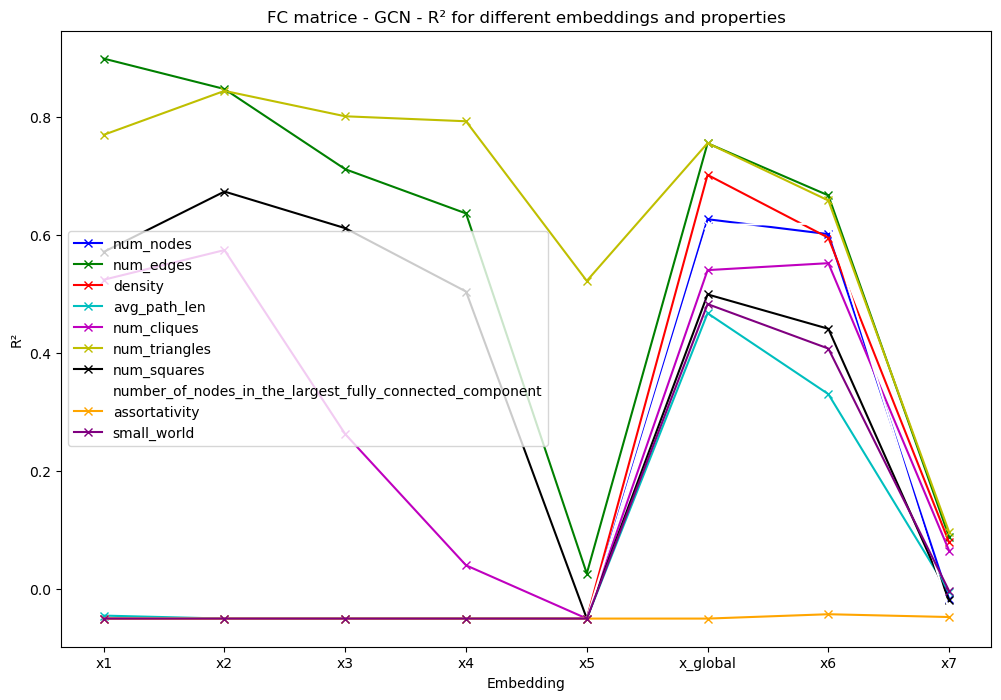

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_full_embedding.png', dpi=300, bbox_inches='tight')

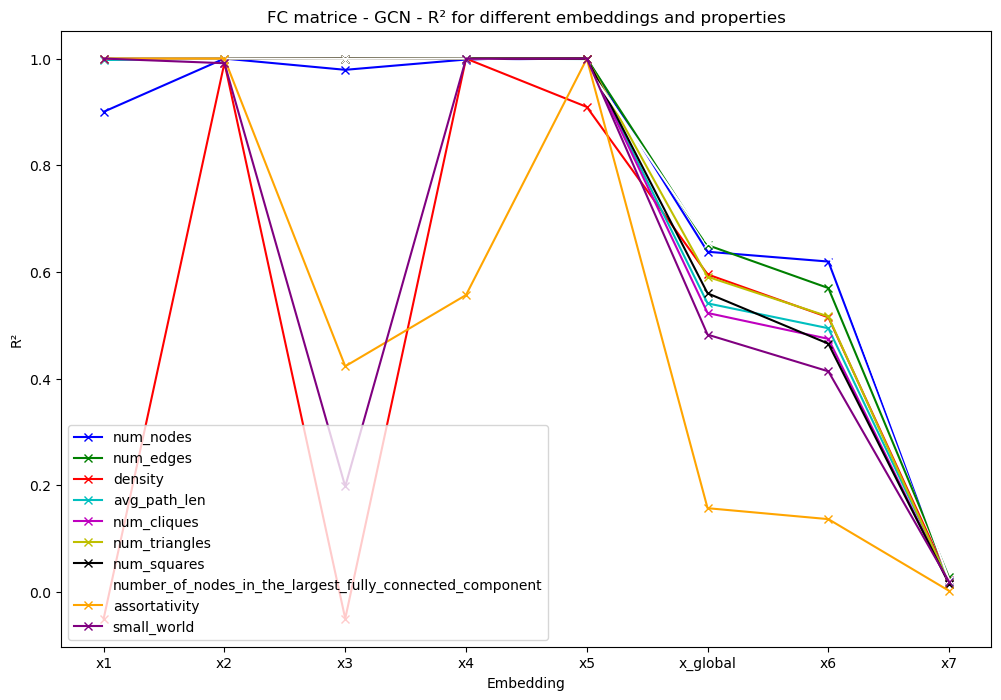

<Figure size 640x480 with 0 Axes>

In [17]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_full_embedding.png', dpi=300, bbox_inches='tight')

# Test with more properties

In [ ]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties


train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



In [18]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [ ]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
# print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7651293/ipykernel_3795878/2942919217.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)


torch.Size([1523, 14848])
torch.Size([81, 14848])
Epoch [1000/2000000], Property: num_nodes, Loss: 2.9861
Epoch [2000/2000000], Property: num_nodes, Loss: 0.3526
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0454
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0162
Epoch [5000/2000000], Property: num_nodes, Loss: 0.0081
Epoch [6000/2000000], Property: num_nodes, Loss: 0.0031
Epoch [7000/2000000], Property: num_nodes, Loss: 0.0009
Epoch [8000/2000000], Property: num_nodes, Loss: 0.0002
Epoch [9000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [10000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [11000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [12000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [13000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [14000/2000000], Property: num_nodes, Loss: 0.1017
Epoch [15000/2000000], Property: num_nodes, Loss: 0.0000
Early stopping at epoch 15195
Embedding: torch.Size([1523, 116, 128])
Property: num_nodes
  Train MSE: 0

Epoch [14000/2000000], Property: num_triangles, Loss: 2.9845
Epoch [15000/2000000], Property: num_triangles, Loss: 0.8884
Epoch [16000/2000000], Property: num_triangles, Loss: 0.2504
Epoch [17000/2000000], Property: num_triangles, Loss: 0.0477
Epoch [18000/2000000], Property: num_triangles, Loss: 0.0104
Epoch [19000/2000000], Property: num_triangles, Loss: 0.0022
Epoch [20000/2000000], Property: num_triangles, Loss: 0.0207
Epoch [21000/2000000], Property: num_triangles, Loss: 0.0001
Epoch [22000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [23000/2000000], Property: num_triangles, Loss: 0.0613
Epoch [24000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [25000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [26000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [27000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [28000/2000000], Property: num_triangles, Loss: 0.0004
Epoch [29000/2000000], Property: num_triangles, Loss: 0.0000
Early stopping at epoch 

In [19]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16244\3867355386.py", line 2, in <module>
    with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 284, in _modified_open
    return io_open(file, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: 'results/FC_MDD_GCN_results_limited_cv_long_full_embedding.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPyth

In [ ]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long_full_embedding.png', dpi=300, bbox_inches='tight')

In [ ]:
#print the R2 values in order (bigger to smaller) for x_global

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

#sort the R2 values for x_global
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x_global', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.6090954542160034, 0.5785549283027649, 0.5785547494888306, 0.5710922479629517, 0.5627355575561523, 0.5171620845794678, 0.48370879888534546, 0.481626033782959, 0.47943955659866333, 0.47933870553970337, 0.4641278386116028, 0.4609038829803467, 0.45253467559814453, 0.4325084686279297, 0.4175136089324951, 0.3686663508415222, 0.3647555112838745, 0.18807393312454224, 0.13714563846588135, 0.04869192838668823, -0.05669963359832764, -0.09409618377685547, -1.3222777843475342]
['num_squares', 'graph_energy', 'num_edges', 'avg_degree', 'density', 'transitivity', 'small_world_index', 'avg_path_len', 'avg_clustering', 'clustering_coeff', 'spectral_radius', 'num_cliques', 'avg_betweenness_centrality', 'algebraic_connectivity', 'num_triangles', 'radius', 'diameter', 'largest_component_size', 'pagerank_cent', 'assortativity', 'num_nodes', 'small_world_coefficient', 'betweenness_cent']


In [ ]:
#same for x6

#sort the R2 values for x6
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x6', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.522092878818512, 0.522091269493103, 0.5128549337387085, 0.5025855898857117, 0.4524869918823242, 0.4169384837150574, 0.4147563576698303, 0.4137481451034546, 0.4122782349586487, 0.39186936616897583, 0.3865439295768738, 0.37806111574172974, 0.35091328620910645, 0.33920663595199585, 0.3346071243286133, 0.3290066123008728, 0.3087393045425415, 0.29865479469299316, 0.16403818130493164, 0.060342609882354736, -0.09877514839172363, -0.14251136779785156, -0.22295606136322021]
['graph_energy', 'num_edges', 'avg_degree', 'density', 'avg_path_len', 'num_cliques', 'algebraic_connectivity', 'avg_betweenness_centrality', 'radius', 'small_world_index', 'diameter', 'spectral_radius', 'num_squares', 'num_triangles', 'avg_clustering', 'clustering_coeff', 'largest_component_size', 'transitivity', 'betweenness_cent', 'pagerank_cent', 'num_nodes', 'small_world_coefficient', 'assortativity']


In [ ]:
#same for x7

#sort the R2 values for x7
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x7', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.0011767745018005371, 1.1265277862548828e-05, -0.006779909133911133, -0.006829738616943359, -0.007808685302734375, -0.007820963859558105, -0.009294867515563965, -0.010425329208374023, -0.01376485824584961, -0.016520977020263672, -0.016980409622192383, -0.01721322536468506, -0.017390012741088867, -0.017391204833984375, -0.024333953857421875, -0.025952935218811035, -0.026882529258728027, -0.02892780303955078, -0.02993631362915039, -0.03466188907623291, -0.051340341567993164, -0.06316637992858887, -0.08530426025390625]
['spectral_radius', 'num_triangles', 'avg_clustering', 'clustering_coeff', 'small_world_index', 'radius', 'largest_component_size', 'diameter', 'avg_path_len', 'avg_betweenness_centrality', 'density', 'avg_degree', 'num_edges', 'graph_energy', 'transitivity', 'num_squares', 'pagerank_cent', 'assortativity', 'algebraic_connectivity', 'betweenness_cent', 'num_cliques', 'num_nodes', 'small_world_coefficient']


In [ ]:
plt.figure(figsize=(12, 8))
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']


for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long_full_embedding.png', dpi=300, bbox_inches='tight')
    

# Comparison with a gnn train on random (the y are shuffled)

In [ ]:
dataset = read_dataset_MDD()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_MDD_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

print(gnn.model)
print(gnn.train_idx)

In [ ]:
#shuffle the y values of the dataset
# import numpy as np
# import torch

# #shuffle the y values of the dataset
# y = np.array([data.y for data in dataset])
# print(y)
# y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# np.random.shuffle(y)

# #make y torch.int64, tensor([0]) instead of [0]
# y = torch.tensor(y, dtype=torch.int64)

# for i in range(len(dataset)):
#     dataset[i].y = y[i]

# # check if the y values are shuffled
# y = np.array([data.y for data in dataset])
# print(y)

In [ ]:
#save the dataset
# import pickle as pkl
# with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "wb") as f:
#     pkl.dump(dataset, f)

#load the dataset
import pickle as pkl
with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "rb") as f:
    dataset = pkl.load(f)

In [ ]:
gnn = framework(dataset)

In [ ]:
# gnn.iterate()

In [ ]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [ ]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt", map_location='cpu')

In [ ]:
gnn.evaluate()

In [ ]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [ ]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [ ]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),     # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random_full_embedding.png')

# Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [ ]:
dataset = read_dataset_MDD()
import torch
torch.manual_seed(37)
MODEL = "GCN_wo_edge_weight"
DATASET = "FC_MDD"
from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model
gnn = framework(dataset)
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")
gnn.evaluate()

##### Node properties

In [ ]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
train_idx[0]

In [ ]:
len(train_node_properties), len(test_node_properties)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(15)]

In [ ]:
import networkx as nx
# Ensure gnn.test_idx is a list of integers
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Visualize the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[test_idx[0]].edge_index.t().tolist())
nx.draw(G, with_labels=True)


In [ ]:
import matplotlib.pyplot as plt
#represent the node degrees of the first graph in the test set
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 100 for v in node_degrees], cmap='viridis')
plt.show()

In [ ]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


In [ ]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

In [ ]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

In [ ]:
len(train_features), len(test_features)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

In [ ]:
train_features[1][0][115]

#### Embedding probing

##### Probing for the top n nodes on train_features only and averaging the results of the different diagnostic classifiers

In [ ]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=37):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_degrees = [get_top_nodes(graph_props[0], 37) for graph_props in train_node_properties]  # Assuming 0th index is for node degrees
top_nodes_clustering = [get_top_nodes(graph_props[1], 37) for graph_props in train_node_properties]  # Assuming 1st index is for clustering coefficient
top_nodes_betweenness = [get_top_nodes(graph_props[2], 37) for graph_props in train_node_properties]  # Assuming 2nd index is for betweenness centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 37) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 37) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_degrees)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_betweenness)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

##### Probing for the top n nodes with diagnostic classifier trained on the train set and test on the test set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=37):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print(f'Layer {layer+1}, Epoch {epoch}, Loss: {loss.item()}')
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)

    #save the results in a file
    with open("results/"+DATASET+"_"+MODEL+"_X_train_layers.pkl", "wb") as f:
        pkl.dump(X_train_layers, f)

    with open("results/"+DATASET+"_"+MODEL+"_y_train_layers.pkl", "wb") as f:
        pkl.dump(y_train_layers, f)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))


In [ ]:

#save all the variables necessary for the plot
# import pickle as pkl
# with open("results/"+DATASET+"_"+MODEL+"_avg_r2_train_dict_long.pkl", "wb") as f:
#     pkl.dump(avg_r2_train_dict, f)

# with open("results/"+DATASET+"_"+MODEL+"_avg_r2_test_dict_long.pkl", "wb") as f:
#     pkl.dump(avg_r2_test_dict, f)

# with open("results/"+DATASET+"_"+MODEL+"_layers_long.pkl", "wb") as f:
#     pkl.dump(layers, f)

# with open("results/"+DATASET+"_"+MODEL+"_property_names_long.pkl", "wb") as f:
#     pkl.dump(property_names, f)

#load all the variables necessary for the plot
import pickle as pkl
with open("results/"+DATASET+"_"+MODEL+"_avg_r2_train_dict_long.pkl", "rb") as f:
    avg_r2_train_dict = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_avg_r2_test_dict_long.pkl", "rb") as f:
    avg_r2_test_dict = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_layers_long.pkl", "rb") as f:
    layers = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_property_names_long.pkl", "rb") as f:
    property_names = pkl.load(f)

    #load the layer results
with open("results/"+DATASET+"_"+MODEL+"_X_train_layers.pkl", "rb") as f:
    X_train_layers = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_y_train_layers.pkl", "rb") as f:
    y_train_layers = pkl.load(f)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_17916\2978085347.py", line 17, in <module>
    with open("results/"+DATASET+"_"+MODEL+"_avg_r2_train_dict_long.pkl", "rb") as f:
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 284, in _modified_open
    return io_open(file, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: 'results/FC_suffled_GCN_w_edge_weight_avg_r2_train_dict_long.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultra

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

y=1 and y=0 as two different plots

In [ ]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [ ]:
dataset = read_dataset_MDD()
import torch
torch.manual_seed(37)
MODEL = "GCN_wo_edge_weight"
DATASET = "FC_MDD"
from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model
gnn = framework(dataset)
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")
gnn.evaluate()

## Node Properties 

In [ ]:
import networkx as nx
import torch

def compute_node_properties(data, indices):
    properties = []
    for idx in indices:
        graph_data = data[idx]
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Add all nodes to the graph to handle disconnected nodes
        all_nodes = set(range(len(graph_data.x)))
        connected_nodes = set(G.nodes())
        disconnected_nodes = all_nodes - connected_nodes
        
        # Calculate node properties using NetworkX for connected nodes
        degree = dict(G.degree())
        clustering = nx.clustering(G)
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
        pagerank = nx.pagerank(G)

        # Initialize properties with zeros for all nodes
        node_properties = [{'degree': 0, 'clustering': 0, 'betweenness': 0, 'closeness': 0, 'eigenvector': 0, 'pagerank': 0} for _ in all_nodes]
        
        # Store properties for each connected node in the graph
        for node in connected_nodes:
            node_properties[node] = {
                'degree': degree[node],
                'clustering': clustering[node],
                'betweenness': betweenness[node],
                'closeness': closeness[node],
                'eigenvector': eigenvector[node],
                'pagerank': pagerank[node]
            }

        #if there a disconnected nodes : print 
        # if disconnected_nodes:
        #     print(f"Graph {idx}: Disconnected nodes: {disconnected_nodes}")
        #     print(node_properties)

        properties.append(node_properties)
    return properties

# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset, train_idx)
test_node_properties = compute_node_properties(gnn.dataset, test_idx)


## Features

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

In [ ]:
len(train_features), len(test_features)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

In [ ]:
train_features[1][0][115]

In [ ]:
print(len(train_features))
print(len(train_features[0]))
print(train_features[0][0].shape)

In [ ]:
print(len(train_node_properties))
print(len(train_node_properties[0]))
print(train_node_properties[0][0])

## Linear classifier

**Probe**

Example data structure for multiple graphs

train_features: List of graphs, each with multiple layers of features

```plaintext
train_features = [
    [np.array([...]), np.array([...]), ...],  # Graph 1: features for each layer
    [np.array([...]), np.array([...]), ...],  # Graph 2: features for each layer
    ...
]
```
train_node_properties: List of graphs, each with a list of node properties

```plaintext
train_node_properties = [
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 1: properties for each node
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 2: properties for each node
    ...
]
```
test_features and test_node_properties would be similarly structured for the test set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2


### Option 2: Train a Single Classifier Across All Graphs

This approach involves combining data from all graphs to train a single probe for each property across the graphs. This assumes that the properties across different graphs share some common structure that can be captured by a single model. We modify the `evaluate_layer_probes` function to aggregate features and properties across all graphs before training.

This approach results in a single probe being trained for each property at each layer, but the probe is trained on data aggregated from all graphs.

In [ ]:
def evaluate_layer_probes_across_graphs(train_features_list, test_features_list, train_properties_list, test_properties_list):
    num_layers = len(train_features_list[0])  # Assuming all graphs have the same number of layers
    results = []

    num_test_graphs = len(test_features_list)  # Number of graphs in the test set

    for layer_idx in range(num_layers):
        combined_train_features = []
        combined_test_features = []
        combined_train_properties = []
        combined_test_properties = []

        # Aggregate features and properties across all graphs
        for graph_idx in range(len(train_features_list)):
            combined_train_features.append(np.vstack(train_features_list[graph_idx][layer_idx]))

            # Use modulo to cycle through the test graphs
            test_idx = graph_idx % num_test_graphs
            combined_test_features.append(np.vstack(test_features_list[test_idx][layer_idx]))

            combined_train_properties.extend(train_properties_list[graph_idx])
            combined_test_properties.extend(test_properties_list[test_idx])

        combined_train_features = np.vstack(combined_train_features)  # Combine features across graphs
        combined_test_features = np.vstack(combined_test_features)

        # Train and evaluate probe for each property across all graphs
        for property_name in combined_train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in combined_train_properties])
            test_property_values = np.array([node[property_name] for node in combined_test_properties])

            mse, r2 = train_probe_for_layer(combined_train_features, train_property_values, combined_test_features, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results


In [ ]:
results_across_graphs = evaluate_layer_probes_across_graphs(train_features, test_features, train_node_properties, test_node_properties)

#save the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
    pkl.dump(results_across_graphs, f)

In [ ]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "rb") as f:
    results_across_graphs = pkl.load(f)

### Choosing Between Options:

- If our graphs are very similar in nature and you expect the relationships between node embeddings and their properties to be consistent across all graphs, **Option 2** (Single Classifier Across Graphs) will be the better choice.
  
- If our graphs are diverse, or we expect the relationships to vary significantly between graphs, *Option 1* (Separate Classifiers) might be more appropriate.

We experiment with both approaches and compare the performance to see which one gives us the best results : we decided to keep option 2

### Results:

- *Layers and Properties*: The function iterate over the layers and properties to aggregate and visualize the R² scores.
  
- *Mean R² Calculation*: The mean R² scores are calculated for each layer and property. If any R² value is below `-0.05`, it is set to `-0.05` to prevent extreme values from skewing the visualization.

- *Plotting*:
  - *Option 1 (`plot_results_per_graph`)*: Plots a separate line for each graph, allowing you to see how the R² scores vary across layers and graphs.
  - *Option 2 (`plot_results_across_graphs`)*: Plots a single line for each property, aggregating the results across all graphs. This provides a high-level view of how each property behaves across layers when considering all graphs together.
  
We decided to keep option 2 as it makes more sense. This function is designed to visualize the results from the `evaluate_layer_probes_across_graphs` function. It will plot the R² scores for each property across layers, combining the results from all graphs into single lines.


In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
def plot_results_across_graphs(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines, one line per property across all graphs
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    plt.title('R² Scores Across Layers for Different Properties (Aggregated Across Graphs)')
    plt.xticks(layers, [f'Layer {i+1}' for i in layers])  # Set the x-axis labels to layer numbers
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

    # Save the plot
    with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
        pkl.dump(results, f)

In [ ]:
# Plot the results across all graphs
plot_results_across_graphs(results_across_graphs)